<h1 style="text-align:center">Deep Learning   </h1>
<h1 style="text-align:center"> Lab Session 3 - 3 Hours </h1>
<h1 style="text-align:center">Long Short Term Memory (LSTM) for Language Modeling</h1>

<b> Student 1:</b> Collura  
<b> Student 2:</b> Spano
 
 
In this Lab Session,  you will build and train a Recurrent Neural Network, based on Long Short-Term Memory (LSTM) units for next word prediction task. 

Answers and experiments should be made by groups of one or two students. Each group should fill and run appropriate notebook cells. 
Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an pdf document using print as PDF (Ctrl+P). Do not forget to run all your cells before generating your final report and do not forget to include the names of all participants in the group. The lab session should be completed by June 9th 2017.

Send you pdf file to benoit.huet@eurecom.fr and olfa.ben-ahmed@eurecom.fr using **[DeepLearning_lab3]** as Subject of your email.

#  Introduction

You will train a LSTM to predict the next word using a sample short story. The LSTM will learn to predict the next item of a sentence from the 3 previous items (given as input). Ponctuation marks are considered as dictionnary items so they can be predicted too. Figure 1 shows the LSTM and the process of next word prediction. 

<img src="lstm.png" height="370" width="370"> 


Each word (and ponctuation) from text sentences is encoded by a unique integer. The integer value corresponds to the index of the corresponding word (or punctuation mark) in the dictionnary. The network output is a one-hot-vector indicating the index of the predicted word in the reversed dictionnary (Section 1.2). For example if the prediction is 86, the predicted word will be "company". 



You will use a sample short story from Aesop’s Fables (http://www.taleswithmorals.com/) to train your model. 


<font size="3" face="verdana" > <i> "There was once a young Shepherd Boy who tended his sheep at the foot of a mountain near a dark forest.

It was rather lonely for him all day, so he thought upon a plan by which he could get a little company and some excitement.
He rushed down towards the village calling out "Wolf, Wolf," and the villagers came out to meet him, and some of them stopped with him for a considerable time.
This pleased the boy so much that a few days afterwards he tried the same trick, and again the villagers came to his help.
But shortly after this a Wolf actually did come out from the forest, and began to worry the sheep, and the boy of course cried out "Wolf, Wolf," still louder than before.
But this time the villagers, who had been fooled twice before, thought the boy was again deceiving them, and nobody stirred to come to his help.
So the Wolf made a good meal off the boy's flock, and when the boy complained, the wise man of the village said:
"A liar will not be believed, even when he speaks the truth."  "</i> </font>.    







Start by loading the necessary libraries and resetting the default computational graph. For more details about the rnn packages, we suggest you to take a look at https://www.tensorflow.org/api_guides/python/contrib.rnn

In [45]:
import numpy as np
import collections # used to build the dictionary
import random
import time
import pickle # may be used to save your model 
%matplotlib inline
import matplotlib.pyplot as plt
#Import Tensorflow and rnn
import tensorflow as tf
from tensorflow.contrib import rnn  

# Target log path
logs_path = 'lstm_words'
writer = tf.summary.FileWriter(logs_path)

# Next-word prediction task

## Part 1: Data  preparation

### 1.1. Loading data

Load and split the text of our story

In [5]:
def load_data(filename):
    with open(filename) as f:
        data = f.readlines()
    data = [x.strip().lower() for x in data]
    data = [data[i].split() for i in range(len(data))]
    data = np.array(data)
    data = np.reshape(data, [-1, ])
    print(data)
    return data

#Run the cell 
train_file ='data/story.txt'
train_data = load_data(train_file)
print("Loaded training data...")
print(len(train_data))

['there' 'was' 'once' 'a' 'young' 'shepherd' 'boy' 'who' 'tended' 'his'
 'sheep' 'at' 'the' 'foot' 'of' 'a' 'mountain' 'near' 'a' 'dark' 'forest'
 '.' 'it' 'was' 'rather' 'lonely' 'for' 'him' 'all' 'day' ',' 'so' 'he'
 'thought' 'upon' 'a' 'plan' 'by' 'which' 'he' 'could' 'get' 'a' 'little'
 'company' 'and' 'some' 'excitement' '.' 'he' 'rushed' 'down' 'towards'
 'the' 'village' 'calling' 'out' 'wolf' ',' 'wolf' ',' 'and' 'the'
 'villagers' 'came' 'out' 'to' 'meet' 'him' ',' 'and' 'some' 'of' 'them'
 'stopped' 'with' 'him' 'for' 'a' 'considerable' 'time' '.' 'this'
 'pleased' 'the' 'boy' 'so' 'much' 'that' 'a' 'few' 'days' 'afterwards'
 'he' 'tried' 'the' 'same' 'trick' ',' 'and' 'again' 'the' 'villagers'
 'came' 'to' 'his' 'help' '.' 'but' 'shortly' 'after' 'this' 'a' 'wolf'
 'actually' 'did' 'come' 'out' 'from' 'the' 'forest' ',' 'and' 'began' 'to'
 'worry' 'the' 'sheep,' 'and' 'the' 'boy' 'of' 'course' 'cried' 'out'
 'wolf' ',' 'wolf' ',' 'still' 'louder' 'than' 'before' '.' 'but' 't

### 1.2. Symbols encoding

The LSTM input's can only be numbers. A way to convert words (symbols or any items) to numbers is to assign a unique integer to each word. This process is often based on frequency of occurrence for efficient coding purpose.

Here, we define a function to build an indexed word dictionary (word->number). The "build_vocabulary" function builds both:

- Dictionary : used for encoding words to numbers for the LSTM inputs 
- Reverted dictionnary : used for decoding the outputs of the LSTM into words (and punctuation).

For example, in the story above, we have **113** individual words. The "build_vocabulary" function builds a dictionary with the following entries ['the': 0], [',': 1], ['company': 85],...


In [6]:
def build_vocabulary(words):
    count = collections.Counter(words).most_common()
    dic= dict()
    for word, _ in count:
        dic[word] = len(dic)
    reverse_dic = dict(zip(dic.values(), dic.keys()))
    return dic, reverse_dic

Run the cell below to display the vocabulary

In [7]:
dictionary, reverse_dictionary = build_vocabulary(train_data)
vocabulary_size = len(dictionary) 
print("Dictionary size (Vocabulary size) = ", vocabulary_size)
print("\n")
print("Dictionary : \n")
print(dictionary)
print("\n")
print("Reverted Dictionary : \n" )
print(reverse_dictionary)

Dictionary size (Vocabulary size) =  113


Dictionary : 

{'there': 107, 'good': 38, 'actually': 34, 'rather': 35, 'this': 11, 'from': 36, 'came': 17, 'his': 12, 'complained': 37, 'at': 33, 'still': 39, 'few': 40, 'mountain': 41, 'company': 42, 'twice': 43, 'foot': 44, 'so': 13, 'meet': 45, 'with': 88, 'shortly': 46, 'will': 47, 'by': 48, 'he': 7, 'even': 51, 'dark': 52, 'all': 53, 'fooled': 101, "boy's": 55, 'cried': 56, 'louder': 57, 'lonely': 58, 'villagers': 14, 'him': 15, 'to': 6, 'course': 59, 'it': 60, 'liar': 61, 'time': 18, 'considerable': 62, 'the': 0, 'tended': 63, 'village': 19, 'rushed': 49, 'trick': 64, 'forest': 20, 'wise': 80, 'man': 67, 'had': 66, 'help': 22, 'meal': 91, 'could': 81, 'but': 23, 'after': 68, 'pleased': 69, 'began': 70, 'little': 71, 'who': 24, ':': 72, 'worry': 73, '.': 4, 'for': 25, 'them': 26, 'flock': 74, 'before': 27, 'thought': 21, 'excitement': 75, 'did': 77, 'been': 78, 'plan': 79, 'out': 9, 'when': 30, 'sheep,': 82, 'boy': 8, 'day': 83, 'not': 8

## Part 2 : LSTM Model in TensorFlow

Since you have defined how the data will be modeled, you are now to develop an LSTM model to predict the word of following a sequence of 3 words. 

### 2.1. Model definition

Define a 2-layers LSTM model.  

For this use the following classes from the tensorflow.contrib library:

- rnn.BasicLSTMCell(number of hidden units) 
- rnn.static_rnn(rnn_cell, data, dtype=tf.float32)
- rnn.MultiRNNCell(,)


You may need some tensorflow functions (https://www.tensorflow.org/api_docs/python/tf/) :
- tf.split
- tf.reshape 
- ...




In [8]:
def lstm_model(x, w, b, n_hidden=265, n_input=3, n_layers=2):
    x = tf.reshape(x, [-1, n_input])
    x = tf.split(x, n_input, 1)

    # n LSTM with n_hidden units.
    rnn_cell = rnn.MultiRNNCell([rnn.BasicLSTMCell(n_hidden) for _ in range(n_layers)])

    outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)
    
    return tf.matmul(outputs[-1], w['out']) + b['out']

Training Parameters, constants the Loss/Cost and optimizer

In [21]:
def define_graph(learning_rate=0.001, n_input=3, n_layers=2, n_hidden=64):
    """
    # Training Parameters
    learning_rate = 0.001
    epochs = 50000
    display_step = 1000
    n_input = 3
    n_layers = 2
    
    # For each LSTM cell that you initialise, supply a value for the hidden dimension, number of units in LSTM cell
    n_hidden = 64
    """
    tf.reset_default_graph()

    model_path = 'lstm_model/lstm-%d-%d' % (n_layers, n_input)

    # tf Graph input
    x = tf.placeholder("float", [None, n_input, 1])
    y = tf.placeholder("float", [None, vocabulary_size])

    # LSTM  weights and biases
    weights = {'out': tf.Variable(tf.random_normal([n_hidden, vocabulary_size]))}
    biases = {'out': tf.Variable(tf.random_normal([vocabulary_size]))}

    # build the model
    pred = lstm_model(x, weights, biases, n_hidden=n_hidden, n_input=n_input, n_layers=n_layers)

    # Loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))  # Cross Entropy loss
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)  # use RMSProp Optimizer

    # Model evaluation
    correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    return x, y, weights, biases, pred, cost, optimizer, correct_pred, accuracy, model_path

We give you here the Test Function

In [22]:
#run the cell
def test(sentence, session, verbose=False):
    sentence = sentence.strip()
    words = sentence.split(' ')
    if len(words) != n_input:
        print("sentence length should be equal to", n_input, "!")
    try:
        symbols_inputs = [dictionary[str(words[i - n_input])] for i in range(n_input)]
        keys = np.reshape(np.array(symbols_inputs), [-1, n_input, 1])
        onehot_pred = session.run(pred, feed_dict={x: keys})
        onehot_pred_index = int(tf.argmax(onehot_pred, 1).eval())
        words.append(reverse_dictionary[onehot_pred_index])
        sentence = " ".join(words)
        if verbose:
            print(sentence)
        return reverse_dictionary[onehot_pred_index]
    except:
        print(" ".join(["Word", words[i - n_input], "not in dictionary"]))

## Part 3 : LSTM Training  

In the Training process, at each epoch, 3 words are taken from the training data, encoded to integer to form the input vector. The training labels are one-hot vector encoding the word that comes after the 3 inputs words. Display the loss and the training accuracy every 1000 iteration. Save the model at the end of training in the **lstm_model** folder

In [48]:
def lstm_training(x, y, weights, biases, pred, cost, optimizer, correct_pred, 
                  accuracy, model_path, n_input, epochs=30000, display_step=1000):
    # Initializing the variables
    start_time = time.time()
    init = tf.global_variables_initializer()
    model_saver = tf.train.Saver()
    
    losses = []
    accuracies = []

    # Launch the graph
    with tf.Session() as session:
        session.run(init)

        print("Start Training")
        step = 0
        offset = random.randint(0, n_input + 1)
        end_offset = n_input + 1
        acc_total = 0
        loss_total = 0

        writer.add_graph(session.graph)

        for step in range(epochs):
            # Generate a minibatch. Add some randomness on selection process.
            if offset > (len(train_data) - end_offset):
                offset = random.randint(0, n_input + 1)

            symbols_in_keys = [[dictionary[str(train_data[i])]] for i in range(offset, offset+n_input)]
            symbols_in_keys = np.reshape(np.array(symbols_in_keys), [-1, n_input, 1])

            symbols_out_onehot = np.zeros([vocabulary_size], dtype=float)
            symbols_out_onehot[dictionary[str(train_data[offset+n_input])]] = 1.0
            symbols_out_onehot = np.reshape(symbols_out_onehot,[1,-1])

            _, acc, loss, onehot_pred = session.run([optimizer, accuracy, cost, pred], \
                                                    feed_dict={x: symbols_in_keys, y: symbols_out_onehot})
            loss_total += loss
            acc_total += acc
            
            if (step + 1) % display_step == 0:    
                losses.append(loss_total / display_step)
                accuracies.append(100 * acc_total / display_step)
                
                print("Iter = " + str(step + 1) + ", Average Loss = " + \
                      "{:.6f}".format(loss_total / display_step) + ", Average Accuracy = " + \
                      "{:.2f}%".format(100 * acc_total / display_step))
                acc_total = 0
                loss_total = 0
                symbols_in = [train_data[i] for i in range(offset, offset + n_input)]
                symbols_out = train_data[offset + n_input]
                symbols_out_pred = reverse_dictionary[int(tf.argmax(onehot_pred, 1).eval())]
                print("%s - [%s] vs [%s]" % (symbols_in,symbols_out,symbols_out_pred))
            step += 1
            offset += n_input + 1

        print("End Of training Finished!")
        print("time: ",time.time() - start_time)
        print("For tensorboard visualisation run on command line.")
        print("\ttensorboard --logdir=%s" % (logs_path))
        print("and oint your web browser to the returned link")

        # save your model 
        model_saver.save(session, model_path)
        print("Model saved")
        
        return losses, accuracies

In [49]:
n_input=3
n_layers=2
n_hidden=64

x, y, weights, biases, pred, cost, optimizer, correct_pred, accuracy, path = define_graph(learning_rate=0.001,
                                                                                          n_input=n_input,
                                                                                          n_layers=n_layers,
                                                                                          n_hidden=n_hidden)
losses, accuracies = lstm_training(x, y, weights, biases, pred, cost, optimizer, correct_pred, 
                                   accuracy, path, epochs=50000, n_input=n_input)

Start Training
Iter = 1000, Average Loss = 4.604915, Average Accuracy = 6.40%
['believed', ',', 'even'] - [when] vs [and]
Iter = 2000, Average Loss = 4.037460, Average Accuracy = 9.50%
[',', 'even', 'when'] - [he] vs [,]
Iter = 3000, Average Loss = 3.117916, Average Accuracy = 25.10%
['shepherd', 'boy', 'who'] - [tended] vs [.]
Iter = 4000, Average Loss = 2.990904, Average Accuracy = 28.10%
['be', 'believed', ','] - [even] vs [boy's]
Iter = 5000, Average Loss = 2.368033, Average Accuracy = 45.20%
['a', 'young', 'shepherd'] - [boy] vs [stirred]
Iter = 6000, Average Loss = 2.241475, Average Accuracy = 47.90%
['the', 'foot', 'of'] - [a] vs [a]
Iter = 7000, Average Loss = 1.936080, Average Accuracy = 50.60%
['a', 'mountain', 'near'] - [a] vs [a]
Iter = 8000, Average Loss = 1.595894, Average Accuracy = 58.70%
['mountain', 'near', 'a'] - [dark] vs [dark]
Iter = 9000, Average Loss = 1.360159, Average Accuracy = 66.00%
['foot', 'of', 'a'] - [mountain] vs [mountain]
Iter = 10000, Average Loss =

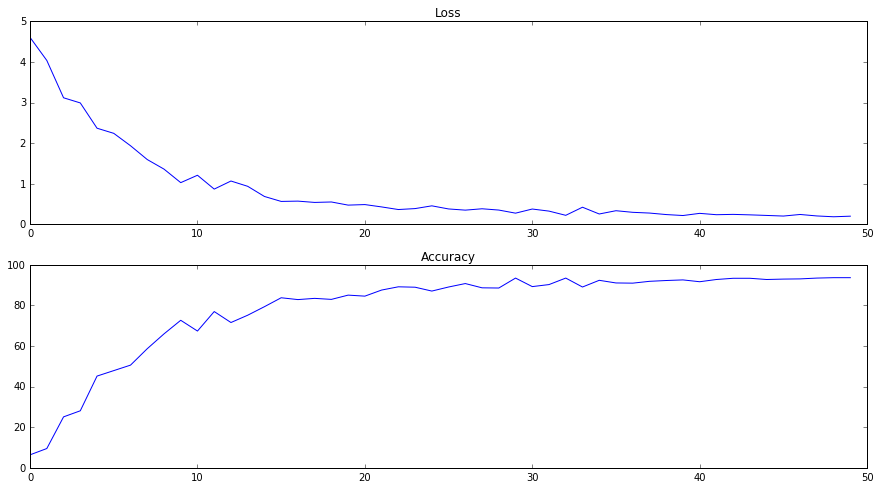

In [52]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
ax1.plot(losses)
ax1.set_title('Loss')
ax2.plot(accuracies)
ax2.set_title('Accuracy')
plt.show()

## Part 4 : Test your model 

### 3.1. Next word prediction

Load your model (using the model_saved variable given in the training session) and test the sentences :
- 'get a little' 
- 'nobody tried to'
- Try with other sentences using words from the story's vocabulary. 

In [53]:
def next_word_prediction(model_path, n_input, sentences=None):
    model_saver = tf.train.Saver()
    with tf.Session() as session:
        model_saver.restore(session, model_path)

        if sentences is not None:
            for sentence in sentences:
                test(sentence, session, True)
            print('\n')

        sentences = [train_data[n:n + n_input + 1] for n in np.random.randint(0, len(train_data) - n_input - 1, 10)]
        for sentence in sentences:
            predicted = test(' '.join(sentence[:-1]), session, True)
            print(' Predicted word:', predicted, '\n Word from text:', sentence[-1])
            
next_word_prediction(path, n_input, sentences=['get a little', 'nobody tried to'])

get a little company
nobody tried to come


worry the sheep, and
 Predicted word: and 
 Word from text: and
help . so the
 Predicted word: the 
 Word from text: the
: a liar will
 Predicted word: will 
 Word from text: will
the boy so much
 Predicted word: much 
 Word from text: much
boy's flock , so
 Predicted word: so 
 Word from text: and
by which he could
 Predicted word: could 
 Word from text: could
after this a wolf
 Predicted word: wolf 
 Word from text: wolf
came out to meet
 Predicted word: meet 
 Word from text: meet
could get a little
 Predicted word: little 
 Word from text: little
fooled twice before ,
 Predicted word: , 
 Word from text: ,


### 3.2. More fun with the Fable Writer !

You will use the RNN/LSTM model learned in the previous question to create a
new story/fable.
For this you will choose 3 words from the dictionary which will start your
story and initialize your network. Using those 3 words the RNN will generate
the next word or the story. Using the last 3 words (the newly predicted one
and the last 2 from the input) you will use the network to predict the 5
word of the story.. and so on until your story is 5 sentence long. 
Make a point at the end of your story. 
To implement that, you will use the test function. 

In [54]:
def generate_fable(model_path, n_input):
    model_saver = tf.train.Saver()
    with tf.Session() as session:
        model_saver.restore(session, model_path)
        n = np.random.randint(0, len(train_data) - n_input)
        words = train_data[n:n + n_input].tolist()
        while words.count('.') < 5 and len(words) < 1000:  # set an upper bound on iterations
            sentence = ' '.join(words[-n_input:])
            words.append(test(sentence, session))

    if words[-1] != '.':
        words.append('.')
    return ' '.join(words)

print(generate_fable(path, n_input))

his help . but shortly after this a wolf actually did come out from the forest , and began stirred to to , wolf , still louder than before . but this time the villagers , who had been fooled twice before , thought the boy was again deceiving them , and nobody stirred to come to his help . but shortly after this a wolf actually did come out from the forest , and began stirred to to , wolf , still louder than before . but this time the villagers , who had been fooled twice before , thought the boy was again deceiving them , and nobody stirred to come to his help .


<div class='alert alert-warning'>
As we can see, we get stuck in a loop. This is due to the fact that the window of words we consider for the prediction is too small: we only look at the previous 3 words to get the next one, so for example, every time we start from "a few days" we will always predict "not", every time we start from "few days not", we will get "he" and so on. We will see if increasing the window of input words to 5 will solve the problem.
</div>

### 3.3. Play with number of inputs

The number of input in our example is 3, see what happens when you use other number (1 and 5)

#### 3.3.1 Number of inputs = 5

In [55]:
n_input=5
n_layers=2
n_hidden=64

x, y, weights, biases, pred, cost, optimizer, correct_pred, accuracy, path = define_graph(learning_rate=0.001,
                                                                                          n_input=n_input,
                                                                                          n_layers=n_layers,
                                                                                          n_hidden=n_hidden)
losses, accuracies = lstm_training(x, y, weights, biases, pred, cost, optimizer, 
                                  correct_pred, accuracy, path,
                                  epochs=50000, n_input=n_input)

Start Training
Iter = 1000, Average Loss = 4.534271, Average Accuracy = 4.20%
[',', 'who', 'had', 'been', 'fooled'] - [twice] vs [,]
Iter = 2000, Average Loss = 3.492237, Average Accuracy = 15.70%
['cried', 'out', 'wolf', ',', 'wolf'] - [,] vs [,]
Iter = 3000, Average Loss = 3.140568, Average Accuracy = 25.20%
['days', 'afterwards', 'he', 'tried', 'the'] - [same] vs [same]
Iter = 4000, Average Loss = 2.300298, Average Accuracy = 44.20%
['could', 'get', 'a', 'little', 'company'] - [and] vs [.]
Iter = 5000, Average Loss = 1.349931, Average Accuracy = 65.60%
[',', 'the', 'wise', 'man', 'of'] - [the] vs [again]
Iter = 6000, Average Loss = 1.511263, Average Accuracy = 66.90%
['so', 'the', 'wolf', 'made', 'a'] - [good] vs [good]
Iter = 7000, Average Loss = 0.828632, Average Accuracy = 81.00%
['come', 'out', 'from', 'the', 'forest'] - [,] vs [,]
Iter = 8000, Average Loss = 0.525453, Average Accuracy = 85.70%
['a', 'considerable', 'time', '.', 'this'] - [pleased] vs [pleased]
Iter = 9000, Aver

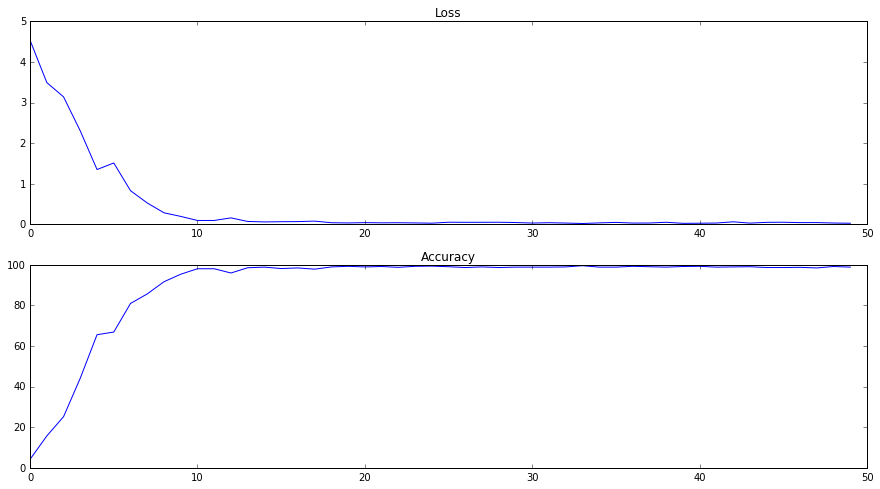

In [58]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
ax1.plot(losses)
ax1.set_title('Loss')
ax2.plot(accuracies)
ax2.set_title('Accuracy')
plt.show()

<div class='alert alert-warning'>
In this case, we notice that we converge pretty easily to a very low loss value and almost a 100% accuracy in a small set of iterations.
</div>

In [56]:
next_word_prediction(path, n_input)

thought the boy was again deceiving
 Predicted word: deceiving 
 Word from text: deceiving
but this time the villagers ,
 Predicted word: , 
 Word from text: ,
who had been fooled twice before
 Predicted word: before 
 Word from text: before
by which he could get a
 Predicted word: a 
 Word from text: a
did come out from the forest
 Predicted word: forest 
 Word from text: forest
. it was rather lonely for
 Predicted word: for 
 Word from text: for
could get a little company and
 Predicted word: and 
 Word from text: and
wolf , and the villagers came
 Predicted word: came 
 Word from text: came
, even when he speaks the
 Predicted word: the 
 Word from text: the
there was once a young shepherd
 Predicted word: shepherd 
 Word from text: shepherd


In [57]:
print(generate_fable(path, n_input))

the sheep, and the boy of course cried out wolf , wolf , and the villagers came out to meet him , and some of them stopped with him for a considerable time . this pleased the boy so much that a few days afterwards he tried the same trick , and again the villagers came to his help . but shortly after this a wolf actually did come out from the forest , and began to worry the sheep, and the boy of course cried out wolf , wolf , and the villagers came out to meet him , and some of them stopped with him for a considerable time . this pleased the boy so much that a few days afterwards he tried the same trick , and again the villagers came to his help . but shortly after this a wolf actually did come out from the forest , and began to worry the sheep, and the boy of course cried out wolf , wolf , and the villagers came out to meet him , and some of them stopped with him for a considerable time .


<font size="3" face="verdana" > <i> "There was once a young Shepherd Boy who tended his sheep at the foot of a mountain near a dark forest.

It was rather lonely for him all day, so he thought upon a plan by which he could get a little company and some excitement.
He rushed down towards the village calling out "Wolf, Wolf," and the villagers came out to meet him, and some of them stopped with him for a considerable time.
This pleased the boy so much that a few days afterwards he tried the same trick, and again the villagers came to his help.
But shortly after this a Wolf actually did come out from the forest, and began to worry the sheep, and the boy of course cried out "Wolf, Wolf," still louder than before.
But this time the villagers, who had been fooled twice before, thought the boy was again deceiving them, and nobody stirred to come to his help.
So the Wolf made a good meal off the boy's flock, and when the boy complained, the wise man of the village said:
"A liar will not be believed, even when he speaks the truth."  "</i> </font>.    







<div class='alert alert-warning'>
As we can see the text we obtain is exactly the same as the original. We believe this is due to overfitting on the training data: in fact, the window of words we train on is too big, and we end up guessing all the right words.
</div>

#### 3.3.2 Number of inputs = 1

In [59]:
n_input=1
n_layers=2
n_hidden=64

x, y, weights, biases, pred, cost, optimizer, correct_pred, accuracy, path = define_graph(learning_rate=0.001,
                                                                                          n_input=n_input,
                                                                                          n_layers=n_layers,
                                                                                          n_hidden=n_hidden)
losses, accuracies = lstm_training(x, y, weights, biases, pred, cost, optimizer, 
                                  correct_pred, accuracy, path,
                                  epochs=50000, n_input=n_input)

Start Training
Iter = 1000, Average Loss = 4.601986, Average Accuracy = 4.50%
['boy'] - [so] vs [,]
Iter = 2000, Average Loss = 4.083218, Average Accuracy = 9.20%
['so'] - [the] vs [.]
Iter = 3000, Average Loss = 4.035994, Average Accuracy = 9.20%
['.'] - [he] vs [and]
Iter = 4000, Average Loss = 3.901859, Average Accuracy = 9.70%
['the'] - [boy] vs [and]
Iter = 5000, Average Loss = 4.012049, Average Accuracy = 9.20%
['boy'] - [who] vs [the]
Iter = 6000, Average Loss = 3.724730, Average Accuracy = 13.50%
['a'] - [few] vs [and]
Iter = 7000, Average Loss = 3.664440, Average Accuracy = 13.90%
['wolf'] - [made] vs [his]
Iter = 8000, Average Loss = 3.738899, Average Accuracy = 13.20%
['some'] - [excitement] vs [.]
Iter = 9000, Average Loss = 3.776730, Average Accuracy = 13.90%
['the'] - [boy] vs [boy]
Iter = 10000, Average Loss = 3.765504, Average Accuracy = 12.30%
['a'] - [young] vs [and]
Iter = 11000, Average Loss = 3.869902, Average Accuracy = 12.40%
['afterwards'] - [he] vs [a]
Iter = 1

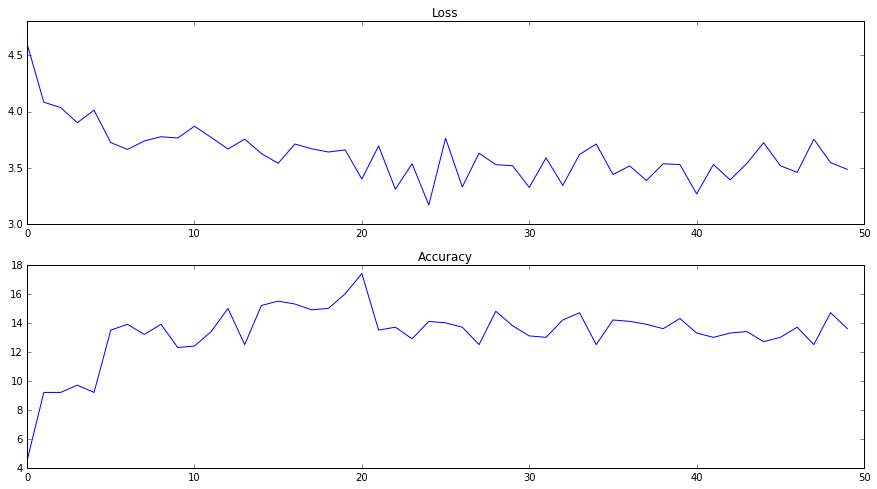

In [60]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
ax1.plot(losses)
ax1.set_title('Loss')
ax2.plot(accuracies)
ax2.set_title('Accuracy')
plt.show()

In [61]:
next_word_prediction(path, n_input)

. his
 Predicted word: his 
 Word from text: it
for ,
 Predicted word: , 
 Word from text: a
a the
 Predicted word: the 
 Word from text: plan
the boy
 Predicted word: boy 
 Word from text: village
, and
 Predicted word: and 
 Word from text: still
out ,
 Predicted word: , 
 Word from text: from
company the
 Predicted word: the 
 Word from text: and
the boy
 Predicted word: boy 
 Word from text: boy
calling a
 Predicted word: a 
 Word from text: out
made a
 Predicted word: a 
 Word from text: a


<div class='alert alert-warning'>
As expected given the low accuracy obtained in the training phase, we do not have good guesses on the next words in this case.
</div>

In [62]:
print(generate_fable(path, n_input))

could a the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , and the boy , an

<div class='alert alert-warning'>
As happened above with input=3, here we are stuck in a loop and we keep printing the same sentences over again. This is due to the fact that the window is too small, and it predicts only based on the last word: every time it finds "," for example, it will always predict "and" as the following word. Same with "and" and "the" and so on.
</div>

#### 3.3.3 Number of inputs = 4

In [63]:
n_input=4
n_layers=2
n_hidden=64

x, y, weights, biases, pred, cost, optimizer, correct_pred, accuracy, path = define_graph(learning_rate=0.001,
                                                                                          n_input=n_input,
                                                                                          n_layers=n_layers,
                                                                                          n_hidden=n_hidden)
losses, accuracies = lstm_training(x, y, weights, biases, pred, cost, optimizer, 
                                  correct_pred, accuracy, path,
                                  epochs=50000, n_input=n_input)

Start Training
Iter = 1000, Average Loss = 4.492513, Average Accuracy = 5.50%
['when', 'the', 'boy', 'complained'] - [,] vs [and]
Iter = 2000, Average Loss = 3.934577, Average Accuracy = 10.10%
['thought', 'the', 'boy', 'was'] - [again] vs [,]
Iter = 3000, Average Loss = 3.223678, Average Accuracy = 20.60%
['time', 'the', 'villagers', ','] - [who] vs [who]
Iter = 4000, Average Loss = 2.563735, Average Accuracy = 34.00%
['from', 'the', 'forest', ','] - [and] vs [and]
Iter = 5000, Average Loss = 1.944986, Average Accuracy = 48.80%
['that', 'a', 'few', 'days'] - [afterwards] vs [off]
Iter = 6000, Average Loss = 1.375919, Average Accuracy = 64.40%
['with', 'him', 'for', 'a'] - [considerable] vs [considerable]
Iter = 7000, Average Loss = 1.222300, Average Accuracy = 67.90%
['the', 'village', 'calling', 'out'] - [wolf] vs [wolf]
Iter = 8000, Average Loss = 0.831691, Average Accuracy = 78.90%
['upon', 'a', 'plan', 'by'] - [which] vs [which]
Iter = 9000, Average Loss = 0.611127, Average Accura

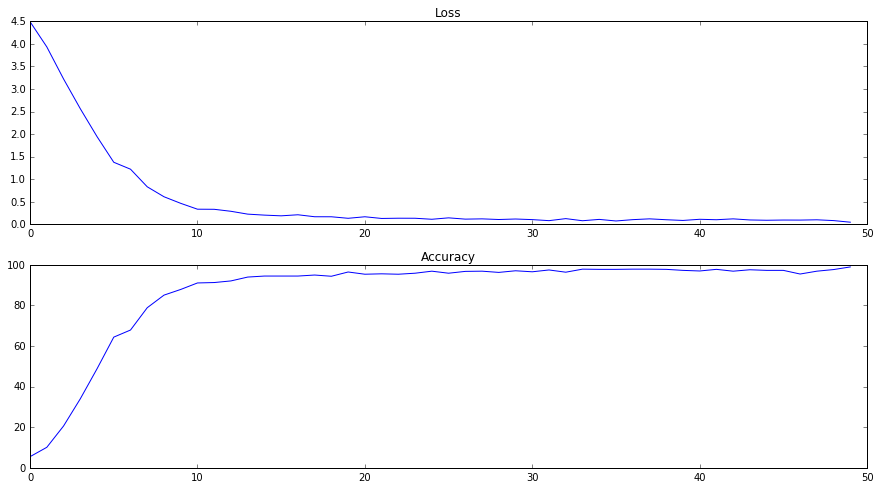

In [64]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
ax1.plot(losses)
ax1.set_title('Loss')
ax2.plot(accuracies)
ax2.set_title('Accuracy')
plt.show()

In [65]:
next_word_prediction(path, n_input)

the villagers , who had
 Predicted word: had 
 Word from text: had
with him for a considerable
 Predicted word: considerable 
 Word from text: considerable
wise man of the village
 Predicted word: village 
 Word from text: village
trick , and again the
 Predicted word: the 
 Word from text: the
help . but shortly after
 Predicted word: after 
 Word from text: after
when the boy complained ,
 Predicted word: , 
 Word from text: ,
the same trick , and
 Predicted word: and 
 Word from text: and
. this pleased the boy
 Predicted word: boy 
 Word from text: boy
. he rushed down towards
 Predicted word: towards 
 Word from text: towards
at the foot of a
 Predicted word: a 
 Word from text: a


In [66]:
print(generate_fable(path, n_input))

excitement . he rushed down towards the village calling out wolf , wolf , still louder than before . but this time the villagers , who had been fooled twice before , thought the boy was again deceiving them , and nobody stirred to come to his help . so the wolf made a good meal afterwards he tried the same trick , and again the boy complained , the wise man of the village said : a liar will not be believed , even when he speaks the truth . the boy of course cried out wolf , wolf , still louder than before .


<font size="3" face="verdana" > <i> "There was once a young Shepherd Boy who tended his sheep at the foot of a mountain near a dark forest.

It was rather lonely for him all day, so he thought upon a plan by which he could get a little company and some excitement.
He rushed down towards the village calling out "Wolf, Wolf," and the villagers came out to meet him, and some of them stopped with him for a considerable time.
This pleased the boy so much that a few days afterwards he tried the same trick, and again the villagers came to his help.
But shortly after this a Wolf actually did come out from the forest, and began to worry the sheep, and the boy of course cried out "Wolf, Wolf," still louder than before.
But this time the villagers, who had been fooled twice before, thought the boy was again deceiving them, and nobody stirred to come to his help.
So the Wolf made a good meal off the boy's flock, and when the boy complained, the wise man of the village said:
"A liar will not be believed, even when he speaks the truth."  "</i> </font>.    







<div class='alert alert-warning'>
In this case, we can see how we are in a midway between n_input = 3 and n_input = 5. We do not obtain exactly the same text as the original one, but we do not get stuck in a loop. 
</div>

## 3-Layers

We increase the number of LSTM layers, while maintaining the number of input words set to 3.

In [68]:
n_input=3
n_layers=3
n_hidden=64

x, y, weights, biases, pred, cost, optimizer, correct_pred, accuracy, path = define_graph(learning_rate=0.001,
                                                                                          n_input=n_input,
                                                                                          n_layers=n_layers,
                                                                                          n_hidden=n_hidden)
losses, accuracies = lstm_training(x, y, weights, biases, pred, cost, optimizer, 
                                  correct_pred, accuracy, path,
                                  epochs=50000, n_input=n_input)

Start Training
Iter = 1000, Average Loss = 4.442622, Average Accuracy = 5.80%
['tended', 'his', 'sheep'] - [at] vs [the]
Iter = 2000, Average Loss = 3.968901, Average Accuracy = 11.80%
['the', 'foot', 'of'] - [a] vs [the]
Iter = 3000, Average Loss = 2.961745, Average Accuracy = 28.00%
['the', 'foot', 'of'] - [a] vs [a]
Iter = 4000, Average Loss = 3.006594, Average Accuracy = 29.10%
['was', 'once', 'a'] - [young] vs [same]
Iter = 5000, Average Loss = 2.011011, Average Accuracy = 46.40%
['even', 'when', 'he'] - [speaks] vs [all]
Iter = 6000, Average Loss = 1.887852, Average Accuracy = 52.10%
['young', 'shepherd', 'boy'] - [who] vs [who]
Iter = 7000, Average Loss = 1.376347, Average Accuracy = 64.20%
['once', 'a', 'young'] - [shepherd] vs [days]
Iter = 8000, Average Loss = 1.537535, Average Accuracy = 60.10%
['shepherd', 'boy', 'who'] - [tended] vs [tended]
Iter = 9000, Average Loss = 1.264431, Average Accuracy = 63.80%
['he', 'speaks', 'the'] - [truth] vs [truth]
Iter = 10000, Average Lo

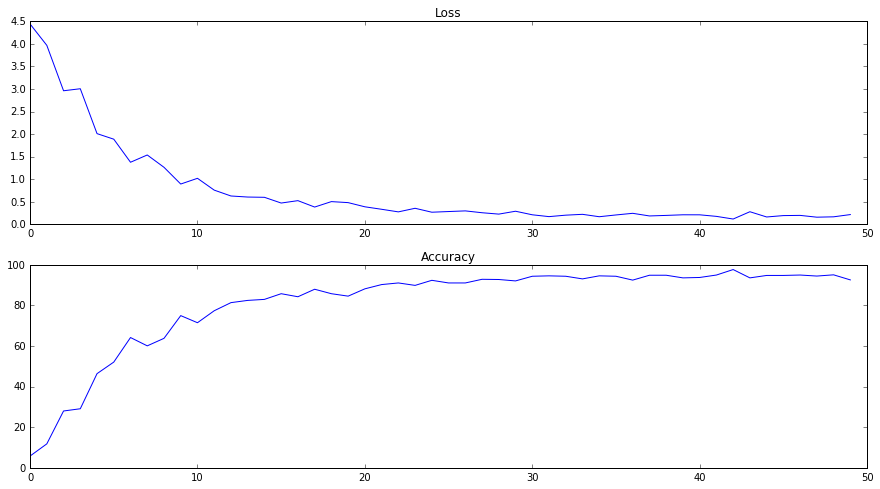

In [69]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
ax1.plot(losses)
ax1.set_title('Loss')
ax2.plot(accuracies)
ax2.set_title('Accuracy')
plt.show()

In [70]:
next_word_prediction(path, n_input)

a dark forest .
 Predicted word: . 
 Word from text: .
off the boy's flock
 Predicted word: flock 
 Word from text: flock
was rather lonely for
 Predicted word: for 
 Word from text: for
complained , the wise
 Predicted word: wise 
 Word from text: wise
stirred to come to
 Predicted word: to 
 Word from text: to
down towards the village
 Predicted word: village 
 Word from text: village
was rather lonely for
 Predicted word: for 
 Word from text: for
, and the villagers
 Predicted word: villagers 
 Word from text: villagers
there was once a
 Predicted word: a 
 Word from text: a
boy was again deceiving
 Predicted word: deceiving 
 Word from text: deceiving


In [71]:
print(generate_fable(path, n_input))

be believed , even when he speaks the truth . the boy of course cried out wolf , wolf , still louder than before . but this time the villagers , who had been fooled the village calling out wolf , wolf , still louder than before . but this time the villagers , who had been fooled the village calling out wolf , wolf , still louder than before . but this time the villagers , who had been fooled the village calling out wolf , wolf , still louder than before .


<div class='alert alert-warning'>
The result is still very close to the one obtained with only 2 LSTM layers.
</div>